# Graph Neural Networks with new dataset

Ming Fong

In [234]:
#import libraries and some constants

import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, LogNorm
import scipy
import pandas as pd
import uproot3 as ur
import tensorflow as tf
import atlas_mpl_style as ampl
from sklearn.neighbors import NearestNeighbors
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from tqdm import tqdm

from graph_nets import blocks
from graph_nets import graphs
from graph_nets import modules
from graph_nets import utils_np
from graph_nets import utils_tf
import networkx as nx


import functools
import networkx as nx
import sonnet as snt


pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 20)

# ampl.use_atlas_style()
params = {'legend.fontsize': 13,
          'axes.labelsize': 18}
plt.rcParams.update(params)

# path_prefix = '/AL/Phd/maxml/'
# plotpath = path_prefix+'caloml-atlas/inputs/Plots/'
# modelpath = path_prefix+'caloml-atlas/classifier/Models/'
# %config InlineBackend.figure_format = 'svg'

# # metadata
# layers = ["EMB1", "EMB2", "EMB3", "TileBar0", "TileBar1", "TileBar2"]
# cell_size_phi = [0.098, 0.0245, 0.0245, 0.1, 0.1, 0.1]
# cell_size_eta = [0.0031, 0.025, 0.05, 0.1, 0.1, 0.2]
# len_phi = [4, 16, 16, 4, 4, 4]
# len_eta = [128, 16, 8, 4, 4, 2]

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)


os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=24220)]) #in MB

print("Num GPUs Available: ", len(gpus))
tf.config.list_physical_devices()

Num GPUs Available:  1


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [36]:
inputpath = "/clusterfs/ml4hep/mfong/ML4Pions/MLTreeData/"
inputpath_pi0 = inputpath + "user.angerami.mc16_13TeV.900246.PG_singlepi0_logE0p2to2000.e8312_e7400_s3170_r12383.v01-45-gaa27bcb_OutputStream/"
inputpath_pion = inputpath + "user.angerami.mc16_13TeV.900247.PG_singlepion_logE0p2to2000.e8312_e7400_s3170_r12383.v01-45-gaa27bcb_OutputStream/"

branches = ['runNumber', 'eventNumber', 'truthE', 'truthPt', 'truthEta',
            'truthPhi', 'clusterIndex', 'nCluster', 'clusterE',
            'clusterECalib', 'clusterPt', 'clusterEta', 'clusterPhi',
            'cluster_nCells', 'cluster_sumCellE', 'cluster_ENG_CALIB_TOT',
            'cluster_ENG_CALIB_OUT_T', 'cluster_ENG_CALIB_DEAD_TOT',
            'cluster_EM_PROBABILITY', 'cluster_HAD_WEIGHT',
            'cluster_OOC_WEIGHT', 'cluster_DM_WEIGHT', 'cluster_CENTER_MAG',
            'cluster_FIRST_ENG_DENS', 'cluster_cell_dR_min',
            'cluster_cell_dR_max', 'cluster_cell_dEta_min',
            'cluster_cell_dEta_max', 'cluster_cell_dPhi_min',
            'cluster_cell_dPhi_max', 'cluster_cell_centerCellEta',
            'cluster_cell_centerCellPhi', 'cluster_cell_centerCellLayer',
            'cluster_cellE_norm']
geo_branches = [
    'cell_geo_ID', 'cell_geo_sampling', 'cell_geo_eta', 'cell_geo_phi',
    'cell_geo_rPerp', 'cell_geo_deta', 'cell_geo_dphi', 'cell_geo_volume',
    'cell_geo_sigma'
]

In [37]:
infile = ur.open(inputpath_pi0 + 'user.angerami.24559740.OutputStream._000011.root')

In [38]:
geo_df = infile['CellGeo'].pandas.df(geo_branches)
geo_df

# eta and phi = pseudorapidity and azimuth angles
# rPerp distance in mm from center



# TODO try adding these later
# cell_geo_deta is size of cell
# cell_geo_dphi is size of cell
# cell_geo_volume is volume of cell

# cell_geo_sigma is noise

cell_geo_ID  cell_geo_sampling  cell_geo_eta  cell_geo_phi  \
entry subentry                                                               
0     0           740294656                  6     -2.559710      0.053900   
      1           740294658                  6     -2.559648      0.151909   
      2           740294660                  6     -2.559603      0.249912   
      3           740294662                  6     -2.559574      0.347912   
      4           740294664                  6     -2.559562      0.445909   
...                     ...                ...           ...           ...   
      187645     1284491536                 15      0.958372     -0.049087   
      187646     1284491824                 17      1.058902     -0.049087   
      187647     1284492080                 17      1.159304     -0.049087   
      187648     1284492592                 17      1.309847     -0.049087   
      187649     1284493104                 17      1.510363     -0.049087   

                cell_geo_rPerp  cell_geo_deta  cell_geo_dphi  cell_geo_volume  \
entry subentry                                                                  
0     0             617.735962            0.1       0.098175     1.697610e+06   
      1             617.774719            0.1       0.098175     1.697610e+06   
      2             617.803223            0.1       0.098175     1.697610e+06   
      3             617.821167            0.1       0.098175     1.697610e+06   
      4             617.828552            0.1       0.098175     1.697610e+06   
...                        ...            ...            ...              ...   
      187645       3215.000000            0.1       0.098175     1.346147e+07   
      187646       2809.000000            0.1       0.098175     1.341334e+06   
      187647       2477.000000            0.1       0.098175     1.241210e+06   
      187648       2060.000000            0.2       0.098175     7.739876e+05   
      187649       1640.000000            0.2       0.098175     4.666501e+05   

                cell_geo_sigma  
entry subentry                  
0     0              49.457161  
      1              49.457161  
      2              49.457161  
      3              49.457161  
      4              49.457161  
...                        ...  
      187645         20.233513  
      187646         10.413343  
      187647         10.957963  
      187648         12.509910  
      187649         11.231500  

[187650 rows x 9 columns]

In [39]:
df_all_cols = infile['EventTree'].pandas.df(flatten=False)
df = df_all_cols[['cluster_cell_ID', 'cluster_cell_E', 'cluster_Eta', 'cluster_Phi']]
df

/global/home/users/mfong/anaconda3/envs/graph/lib/python3.8/site-packages/awkward0/array/base.py:398: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return cls.numpy.array(value, copy=False)


,cluster_cell_ID,cluster_cell_E,cluster_Eta,cluster_Phi
entry,,,,
0,[],[],[],[]
1,"[[759192106, 759192104, 759192108, 759191594, ...","[[77.977806, 24.14488, 4.869435, 2.659961, 21....",[-1.143686],[0.5293207]
2,"[[751056134, 751056132, 751056136, 751055622, ...","[[413.32898, 48.909393, 90.18763, 39.86163, 27...",[-2.0994453],[-3.0541317]
3,"[[751053140, 751053138, 751053142, 751052628, ...","[[1.652616, 0.11616877, 0.71565634, 0.10801599...","[-1.9524345, -1.9014493]","[-2.0981069, -1.982254]"
4,"[[749243440, 749243442, 749242928, 749243952, ...","[[0.25986475, 0.048873316, 0.0951039, 0.186739...",[-1.7287459],[2.4218318]
...,...,...,...,...
19995,"[[749757984, 749757986, 749757472, 749758496, ...","[[0.6816676, 0.008014569, 0.2565823, 0.3002508...",[-2.3337884],[1.6153674]
19996,"[[759180956, 759180954, 759180958, 759180444, ...","[[64.28961, 3.8230877, 12.329029, 2.738421, 3....",[-0.58717525],[1.9303617]
19997,"[[740295258, 740295256, 740295260, 740294746, ...","[[56.3288, 5.3618994, 7.271554, 1.4210855, 1.7...",[-2.6642337],[-1.8128626]


## Checking events with no registered clusters

In [40]:
# df[df["cluster_cell_E"].map(len) == 0]

In [41]:
# test = pd.DataFrame(
#     df_all_cols[df_all_cols["cluster_cell_E"].map(len) == 0]["truthPartStatus"].apply(pd.Series).stack().reset_index(drop=True)
# )
# test.columns = ["truthPartStatus"]
# test["truthPartE"] = df_all_cols[df_all_cols["cluster_cell_E"].map(len) == 0]["truthPartE"].apply(pd.Series).stack().reset_index(drop=True)
# test = test[test["truthPartStatus"] == 1]
# test

In [42]:
# test["truthPartE"].describe()

In [43]:
# plt.hist(test["truthPartE"], bins = [x/100 for x in range(0, 100)], density=True)
# plt.xlabel("truthPartE")
# plt.ylabel("Fraction of Events")
# plt.title("Truth Particles with Status Code 1 (No cluster)")
# plt.axis([0, 1, 0, 3])

# Graph making functions

In [44]:
def geo_df_to_xyz(geo_df):
    """
    Adds xyz coordinates to geo_df
    
    Params:
        geo_df: pd.DataFrame 
    
    Returns:
        geo_df_with_xyz: pd.DataFrame original dataframe plus x y x coordinates for each cell
    
    """
    geo_df["cell_geo_x"] = geo_df["cell_geo_rPerp"] * np.cos(geo_df["cell_geo_phi"])
    geo_df["cell_geo_y"] = geo_df["cell_geo_rPerp"] * np.sin(geo_df["cell_geo_phi"])
    cell_geo_theta = 2 * np.arctan(np.exp(-geo_df["cell_geo_eta"]))
    geo_df["cell_geo_z"] = geo_df["cell_geo_rPerp"] / np.tan(cell_geo_theta)
    return geo_df

In [45]:
geo_df = geo_df_to_xyz(geo_df)

In [82]:
# throw out empty particles in out layer []

# check here for the old code of make_graph()
# https://github.com/evilpegasus/LCStudies/blob/cnn_dev/classifier/TopoClusterClassiferGraph.ipynb

def make_graph(event: pd.Series, geo_df: pd.DataFrame, is_charged):
    """
    Creates a graph representation of an event
    
    inputs
    event (pd.Series) one event/row from EventTree
    geo_df (pd.DataFrame) the CellGeo DataFrame mapping cell_geo_ID to information about the cell
    is_charged (bool) True for charged pion, False for uncharged pion
    
    returns
    A graph representation of the event for the GNN
    returns (None, None) if no cell energies detected
    """
    assert len(event["cluster_cell_E"]) == len(event["cluster_cell_ID"]), "Error: Missmatched len of cluster_cell_E and cluster_cell_ID"
    # If no energies were registered return tuple(None, None)
    if len(event["cluster_cell_E"]) == 0:
        return None, None
    
    temp_df = geo_df[geo_df["cell_geo_ID"].isin([item for sublist in event["cluster_cell_ID"] for item in sublist])]
    temp_df = temp_df.set_index("cell_geo_ID")
    for cell_id, cell_e in zip(
        [item for sublist in event["cluster_cell_ID"] for item in sublist],
        [item for sublist in event["cluster_cell_E"] for item in sublist]
    ):
        temp_df.loc[int(cell_id), "cell_E"] = cell_e
    
    
    
    n_nodes = temp_df.shape[0]
    
    nodes = temp_df["cell_E"].to_numpy(dtype=np.float32).reshape(-1,1)
    
    # NOTE FAIR also has a faster algo for KNN search. Might want to try it
    
    k = 5
    k = min(n_nodes, k)
    
    nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(temp_df[["cell_geo_x", "cell_geo_y", "cell_geo_z"]])
    distances, indices = nbrs.kneighbors(temp_df[["cell_geo_x", "cell_geo_y", "cell_geo_z"]])
    
    senders = np.repeat([x[0] for x in indices], k-1)               # k-1 for no self edges
    receivers = np.array([x[1:] for x in indices]).flatten()        # x[1:] for no self edges
    edges = np.array([x[1:] for x in distances], dtype=np.float32).flatten().reshape(-1, 1)
    n_edges = len(senders)
    
    solution = int(is_charged)
    
    input_datadict = {
        "n_node": n_nodes,
        "n_edge": n_edges,
        "nodes": nodes,
        "edges": edges,
        "senders": senders,
        "receivers": receivers,
        "globals": np.array([n_nodes], dtype=np.float32)
    }
    target_datadict = {
        "n_node": n_nodes,
        "n_edge": n_edges,
        "nodes": nodes,
        "edges": edges,
        "senders": senders,
        "receivers": receivers,
        "globals": np.array([solution], dtype=np.float32)
    }
    input_graph = utils_tf.data_dicts_to_graphs_tuple([input_datadict])
    target_graph = utils_tf.data_dicts_to_graphs_tuple([target_datadict])
    
    
    return input_graph, target_graph
#     return temp_df

In [85]:
def print_graphs_tuple(g, data=True):
    for field_name in graphs.ALL_FIELDS:
        per_replica_sample = getattr(g, field_name)
        if per_replica_sample is None:
            print(field_name, "EMPTY")
        else:
            print(field_name, "has shape", per_replica_sample.shape)
            if data and  field_name != "edges":
                print(per_replica_sample)

In [420]:
test_graph_pair = make_graph(df.iloc[2], geo_df, 1)
# test_graph_pair

In [421]:
print_graphs_tuple(test_graph_pair[1], data=False)

nodes has shape (127, 1)
edges has shape (508, 1)
receivers has shape (508,)
senders has shape (508,)
globals has shape (1, 1)
n_node has shape (1,)
n_edge has shape (1,)


In [88]:
# small set of 100 points for testing

graph_list = []
for i in range(100):
    graph_list.append(make_graph(df.loc[i], geo_df, 0))

In [89]:
# print graphs out

# for i, g in enumerate(graph_list):
#     print("Graph", i)
#     if g[0] is None:
#         print(g)
#         continue
#     print_graphs_tuple(g[0], data=False)

In [90]:
# plot a graph

# graphs_nx = utils_np.graphs_tuple_to_networkxs(graph_list[2][0])
# _, axs = plt.subplots(ncols=2, figsize=(20, 10))
# for iax, (graph_nx, ax) in enumerate(zip(graphs_nx, axs)):
#     nx.draw(graph_nx, ax=ax)
#     ax.set_title("Graph {}".format(iax))

In [345]:
pi0_files = os.listdir(inputpath_pi0)[:50]
pion_files = os.listdir(inputpath_pion)[:50]

In [346]:
graph_list = []    # list of outputs from make_graph() in the form (input graph, target graph)

In [ ]:
# create and append pi0 graphs to graph_list

for pi0_file in tqdm(pi0_files, position=0, leave=True):
    infile = ur.open(inputpath_pi0 + pi0_file)
    
    geo_df = infile['CellGeo'].pandas.df(geo_branches)
    geo_df = geo_df_to_xyz(geo_df)
    
    df = infile['EventTree'].pandas.df(flatten=False)[['cluster_cell_ID', 'cluster_cell_E', 'cluster_Eta', 'cluster_Phi']]
    
    for i in tqdm(range(len(df)), position=0, leave=True):
        graph_list.append((make_graph(df.iloc[i], geo_df, 0)))

  0%|          | 0/50 [00:00<?, ?it/s]/global/home/users/mfong/anaconda3/envs/graph/lib/python3.8/site-packages/awkward0/array/base.py:398: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return cls.numpy.array(value, copy=False)
  2%|▏         | 470/20000 [00:09<06:10, 52.71it/s]

In [ ]:
# create and append piplus/piminus graphs to graph_list

for pion_file in tqdm(pion_files, position=0, leave=True):
    infile = ur.open(inputpath_pion + pion_file)
    
    geo_df = infile['CellGeo'].pandas.df(geo_branches)
    geo_df = geo_df_to_xyz(geo_df)
    
    df = infile['EventTree'].pandas.df(flatten=False)[['cluster_cell_ID', 'cluster_cell_E', 'cluster_Eta', 'cluster_Phi']]
    
    for i in tqdm(range(len(df)), position=0, leave=True):
        graph_list.append((make_graph(df.iloc[i], geo_df, 1)))

In [432]:
len(graph_list)

2000000

In [433]:
graph_list[2][1].globals

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.]], dtype=float32)>

# Graph Net Setup

In [440]:
NUM_LAYERS = 2
DROPOUT_RATE = 0.1
def make_mlp_model():
  """Instantiates a new MLP, followed by LayerNorm.

  The parameters of each new MLP are not shared with others generated by
  this function.

  Returns:
    A Sonnet module which contains the MLP and LayerNorm.
  """
  # the activation function choices:
  # swish, relu, relu6, leaky_relu
  return snt.Sequential([
#       snt.nets.MLP([128, 64]*NUM_LAYERS,
    snt.nets.MLP([128, 64],
        activation=tf.nn.relu,
        activate_final=True, 
#         dropout_rate=DROPOUT_RATE
    ),
    snt.LayerNorm(axis=-1, create_scale=True, create_offset=False)
  ])

In [441]:
class MLPGraphNetwork(snt.Module):
    """GraphIndependent with MLP edge, node, and global models."""
    def __init__(self, name="MLPGraphNetwork"):
        super(MLPGraphNetwork, self).__init__(name=name)
        self._network = modules.GraphNetwork(
            edge_model_fn=make_mlp_model,
            node_model_fn=make_mlp_model,
            global_model_fn=make_mlp_model
            )

    def __call__(self, inputs,
            edge_model_kwargs=None,
            node_model_kwargs=None,
            global_model_kwargs=None):
        return self._network(inputs,
                      edge_model_kwargs=edge_model_kwargs,
                      node_model_kwargs=node_model_kwargs,
                      global_model_kwargs=global_model_kwargs)

In [442]:
LATENT_SIZE = 128
NUM_LAYERS = 3

class GlobalClassifier(snt.Module):

    def __init__(self, name="GlobalClassifier"):
        super(GlobalClassifier, self).__init__(name=name)

        self._edge_block = blocks.EdgeBlock(
            edge_model_fn=make_mlp_model,
            use_edges = True,
            use_receiver_nodes = True,
            use_sender_nodes = True,
            use_globals = True,            # can try true later
            name='edge_encoder_block')

        self._node_encoder_block = blocks.NodeBlock(
            node_model_fn=make_mlp_model,
            use_received_edges=True,      # if assigning edge features set to true
            use_sent_edges=True,          # if assigning edge features set to true
            use_nodes=True,
            use_globals=True,             # can try true later to see if any effect
            name='node_encoder_block'
        )

        self._global_block = blocks.GlobalBlock(
            global_model_fn=make_mlp_model,
            use_edges=True,
            use_nodes=True,
            use_globals=True,
        )

        self._core = MLPGraphNetwork()
        # Transforms the outputs into appropriate shapes.
        global_output_size = 1
        global_fn = lambda: snt.Sequential([
#             snt.nets.MLP([32, 64],),
#             snt.nets.MLP([128, 64],),
            snt.nets.MLP([128, 64, 128, global_output_size], name='global_output'),       # TODO add more layers, end with size 1
            tf.sigmoid
        ])

        self._output_transform = modules.GraphIndependent(None, None, global_fn)

    def __call__(self, input_op, num_processing_steps):
        latent = self._global_block(self._edge_block(self._node_encoder_block(input_op)))
        latent0 = latent

        output_ops = []
        for _ in range(num_processing_steps):
            core_input = utils_tf.concat([latent0, latent], axis=1)
            latent = self._core(core_input)
            output_ops.append(self._output_transform(latent))

        return output_ops

In [443]:
model = GlobalClassifier()
model

GlobalClassifier()

In [444]:
test_graph_pair[1].globals

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[1.]], dtype=float32)>

In [445]:
output_graphs = model(test_graph_pair[0], 1)
output_graphs[0].globals

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.5522311]], dtype=float32)>

In [446]:
# Loss function:

class GlobalLoss:
    def __init__(self, real_global_weight, fake_global_weight):
        self.w_global_real = real_global_weight
        self.w_global_fake = fake_global_weight

    def __call__(self, target_op, output_ops):
        global_weights = target_op.globals * self.w_global_real \
            + (1 - target_op.globals) * self.w_global_fake
        
#         print(global_weights)
        
        loss_ops = [
            tf.compat.v1.losses.log_loss(target_op.globals, output_op.globals, weights=global_weights)
            for output_op in output_ops
        ]
        return tf.stack(loss_ops)

In [447]:
loss_function_global = GlobalLoss(real_global_weight = 1.0, fake_global_weight = 1.0)

In [448]:
loss_function_global(test_graph_pair[1], output_graphs)

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.5937885], dtype=float32)>

In [449]:
def get_signature(dataset, batch_size):
    """
    Get signature of inputs for the training loop.
    The signature is used by tf.function
    """

    input_list = []
    target_list = []
    for _, data in dataset.iterrows():
        dd = make_graph(data, geo_df, 0)
        if dd[0] is not None:
            input_list.append(dd[0])
            target_list.append(dd[1])
            
        if len(input_list) == batch_size:
            break

    inputs = utils_tf.concat(input_list, axis=0)
    targets = utils_tf.concat(target_list, axis=0)
    input_signature = (
      utils_tf.specs_from_graphs_tuple(inputs),
      utils_tf.specs_from_graphs_tuple(targets)
    )
    
    return input_signature

In [450]:
batch_size = 200
input_signature = get_signature(df, batch_size)


# Model parameters.
# Number of processing (message-passing) steps.
num_processing_steps_tr = 2
num_processing_steps_te = 2


learning_rate = 1e-3
optimizer = snt.optimizers.Adam(learning_rate)


# model = models.EncodeProcessDecode(edge_output_size=2, node_output_size=2)
last_iteration = 0
generalization_iteration = 0

logged_iterations = []

losses_tr = []
corrects_tr = []
solveds_tr = []

losses_test = []
corrects_test = []
solveds_test = []


@functools.partial(tf.function, input_signature=input_signature)
def update_step(inputs_tr, targets_tr):
    print("Tracing update_step")
    with tf.GradientTape() as tape:
        outputs_tr = model(inputs_tr, num_processing_steps_tr)
        loss_ops_tr = loss_function_global(targets_tr, outputs_tr)
        loss_op_tr = tf.math.reduce_sum(loss_ops_tr) / tf.constant(num_processing_steps_tr, dtype=tf.float32)

    gradients = tape.gradient(loss_op_tr, model.trainable_variables)
    optimizer.apply(gradients, model.trainable_variables)
    return outputs_tr, loss_op_tr

In [451]:
# train and test sets
graph_list = shuffle(graph_list, random_state=42)
train_graphs, test_graphs = train_test_split(graph_list, test_size = 0.2, random_state = 42)
print("Number of training graph pairs: ", len(train_graphs))
print("Number of testing graph pairs: ", len(test_graphs))

Number of training graph pairs:  1600000
Number of testing graph pairs:  400000


In [ ]:
%%time
# %%capture output

for epoch in range(100):
    total_loss = 0.
    num_batches = 0

    input_list = []
    target_list = []


    # training dataset
    for data in train_graphs:
        input_tr, target_tr = data
        if input_tr is None:
                continue
        input_list.append(input_tr)
        target_list.append(target_tr)
        if len(input_list) >= batch_size:
            input_tr = utils_tf.concat(input_list, axis=0)
            target_tr = utils_tf.concat(target_list, axis=0)

            current_loss = update_step(input_tr, target_tr)[1].numpy()
            total_loss += current_loss

            num_batches += 1
            input_list = []
            target_list = []
    loss_tr = total_loss / num_batches
    losses_tr.append(loss_tr)


    # testing dataset
    total_loss_test = 0.
    num_batches_test = 0
    input_list_test = []
    target_list_test = []
    for data in test_graphs:
        input_test, target_test = data
        if input_test is None:
                continue
        input_list_test.append(input_test)
        target_list_test.append(target_test)
        if len(input_list_test) >= batch_size:
            input_test = utils_tf.concat(input_list, axis=0)
            target_test = utils_tf.concat(target_list, axis=0)
            output_test = model(input_test, num_processing_steps_te)
            loss_ops_test = loss_function_global(target_test, output_test)
            total_loss_test += tf.math.reduce_sum(loss_ops_test) / tf.constant(num_processing_steps_tr, dtype=tf.float32)



            num_batches_test += 1
            input_list_test = []
            target_list_test = []
    loss_test = total_loss_test / num_batches_test
    losses_test.append(loss_test)


    print_string = f"Epoch: {epoch}\tloss_tr: {loss_tr}\tloss_test: {loss_test}"
    with open("log2.txt", "a") as log:
        log.write(print_string + "\n")
    print(print_string)
# TODO add a checkpoint > save to disk

Tracing update_step


/global/home/users/mfong/anaconda3/envs/graph/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


Tracing update_step


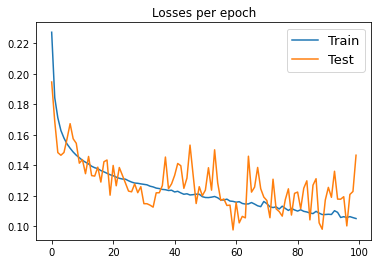

In [453]:
plt.plot(losses_tr, label="Train")
plt.plot(losses_test, label="Test")
plt.legend()
plt.title("Losses per epoch");

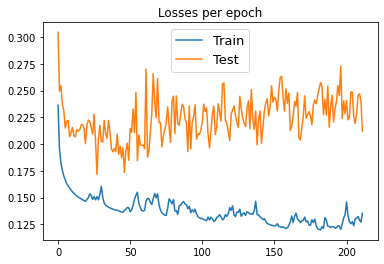

In [403]:
plt.plot(losses_tr, label="Train")
plt.plot(losses_test, label="Test")
plt.legend()
plt.title("Losses per epoch");

In [ ]:
# calc roc curve and auc
test_predictions = []
test_truth = []

input_list_test = []
target_list_test = []
for data in test_graphs:
    input_test, target_test = data
    if input_test is None:
            continue
    input_list_test.append(input_test)
    target_list_test.append(target_test)
    if len(input_list_test) >= batch_size:
        input_test = utils_tf.concat(input_list, axis=0)
        target_test = utils_tf.concat(target_list, axis=0)
        output_test = model(input_test, num_processing_steps_te)
        test_predictions.append(output_test[-1].globals)
        test_truth.append(target_test.globals)

roc_auc: 0.9877600979192166


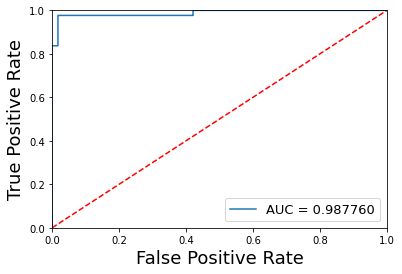

In [406]:
fpr, tpr, thresholds = roc_curve(
    np.array([x.numpy() for x in test_truth]).flatten(),
    np.array([x.numpy() for x in test_predictions]).flatten(),
    pos_label=1
)
roc_auc = auc(fpr, tpr)
print("roc_auc:", roc_auc)
plt.plot(fpr, tpr, label = 'AUC = %0.6f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate');

In [419]:
len(np.array([x.numpy() for x in test_predictions]).flatten())

27714300

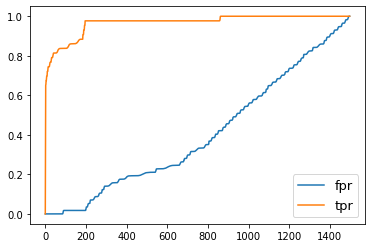

In [407]:
plt.plot(fpr, label="fpr")
plt.plot(tpr, label="tpr")
plt.legend();

In [408]:
print(len(fpr))
print(len(tpr))

1498
1498


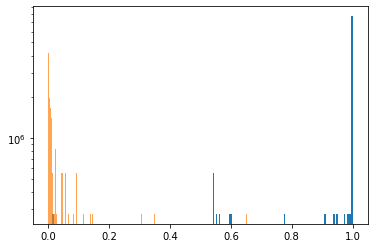

In [409]:
plt.hist(np.array([x.numpy() for x in test_predictions]).flatten()[np.array([x.numpy() for x in test_truth]).flatten() == 1], bins=200)
plt.hist(np.array([x.numpy() for x in test_predictions]).flatten()[np.array([x.numpy() for x in test_truth]).flatten() == 0], alpha=0.7, bins=200)
plt.yscale("log")

In [410]:
len(np.unique(np.array([x.numpy() for x in test_predictions]).flatten()[np.array([x.numpy() for x in test_truth]).flatten() == 1]))

207

In [411]:
len(np.unique(np.array([x.numpy() for x in test_predictions]).flatten()[np.array([x.numpy() for x in test_truth]).flatten() == 0]))

1332